## Dataset

**Data fields:**
    
- **Patient_ID** - The unique identifier of the patient
- **Family_Case_ID** - The family identification
- **Severity** - The severity of the disease, where 1 is the lowest and 3 the highest severity
- **Name** - The name of the patient
- **Birthday_year** - The year of birthday of the patient
- **Parents_Siblings_Infected** - The number of parents and/or siblings infected
- **Partner_Children_Infected** - The number of partner and/or children infected
- **Medical_Expenses_Family** - The medical expenses associated to try to contain the epidemy on the family
- **Medical_Tent** - The medical tent where the patient is / was lodged
- **City** - The original city of the patient
- **Deceased** - Flag if the patient deceased or not with the virus (0 = No, 1 = Yes)

## Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import KNNImputer

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sb
import math
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder


## Functions

In [2]:
def avg_score(model):
    # apply kfold
    kf = KFold(n_splits=5)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    n_iter = []
    for train_index, test_index in kf.split(X):
        # get the indexes of the observations assigned for each partition
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_test,y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
        n_iter.append(model.n_iter_)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_iter = round(np.mean(n_iter),1)
    std_iter = round(np.std(n_iter),1)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test), str(avg_iter) + '+/-' + str(std_iter)

In [3]:
def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test, avg_iter = avg_score(arg)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test, avg_iter
        count+=1
    return df

In [4]:
def cor_heatmap(cor):
    plt.figure(figsize=(20,20))
    sb.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [5]:
def plt_box(data):
    n_col = 2
    n_row = 2
    fig, ax = plt.subplots(n_row, n_col, figsize=(15, 10))
    for var, subplot in zip(data[numerical], ax.flatten()):
        sb.boxplot(data[var], ax=subplot)

In [6]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

 ## Data exploration

### Full dataset exploration

preprocess as types 
year as integer 
patient_id and Family case as text

In [7]:
Pandemic = pd.read_csv("train.csv")
Pandemic.describe(include='all')

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
count,900.000000,900.000000,900.000000,900,723.000000,900.000000,900.000000,900.000000,198,898,900.000000
unique,NaN,NaN,NaN,899,NaN,NaN,NaN,NaN,8,3,NaN
top,NaN,NaN,NaN,Mr. Samuel Darnell,NaN,NaN,NaN,NaN,C,Santa Fe,NaN
freq,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,57,649,NaN
mean,450.500000,14305.827778,2.313333,NaN,1990.266943,0.380000,0.521111,895.743333,NaN,NaN,0.614444
std,259.951919,25418.153900,0.834223,NaN,14.523335,0.803247,1.098385,1385.829926,NaN,NaN,0.486997
min,1.000000,345.000000,1.000000,NaN,1940.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
25%,225.750000,8203.000000,2.000000,NaN,1982.000000,0.000000,0.000000,221.000000,NaN,NaN,0.000000
50%,450.500000,13593.500000,3.000000,NaN,1992.000000,0.000000,0.000000,405.000000,NaN,NaN,1.000000
75%,675.250000,18906.500000,3.000000,NaN,1999.500000,0.000000,1.000000,861.250000,NaN,NaN,1.000000


In [8]:
# Check missing values
print(Pandemic.isnull().sum())

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64


**Initial considerations:**

We have 900 patients records
* one patient name repeats once but looking at the patients info we conclude these are two different people with same names
* Families can be tracked by Family_case_ID
* Birthday Year not available for everyone - fill in with KNNFiller? Also easier to work with age so will create a column "Age"(as of January 1st, 2020 when epidemic started)
* City has two missing values - fill in with KNNImputer?
* Medical tent can be unknown? (are there patients without tent or its data collection error?) so we cannot realy extrapolate these values and there are too many patients without Tent (almost 80%)
* Medical tent has many categories (8). This can indicate an issue with distribution. Can convert to binary (Tent - Yes-No).
* target value (deceased or not) is evenly distributed



In [9]:
# Exploration of categorical variables: cross table of Tents and city and severity of infection
table1 = pd.crosstab(index=Pandemic['City'], columns=Pandemic['Severity'])
table1

Severity,1,2,3
City,,,
Albuquerque,85,17,67
Santa Fe,127,165,357
Taos,2,4,74


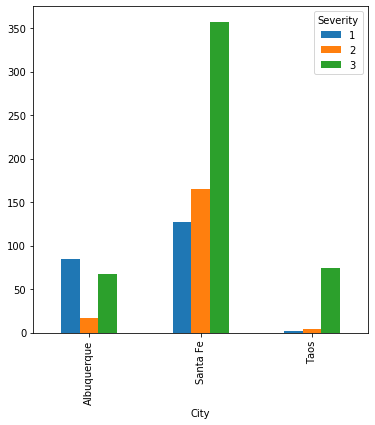

In [10]:
# Visual exploration of the cross table
table1.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=False)

In [11]:
table1 = pd.crosstab(index=Pandemic['Medical_Tent'], columns=Pandemic['Severity'])
table1

Severity,1,2,3
Medical_Tent,,,
A,15,0,0
B,46,0,0
C,56,0,1
D,27,4,0
E,24,4,3
F,0,8,5
G,0,0,4
T,1,0,0


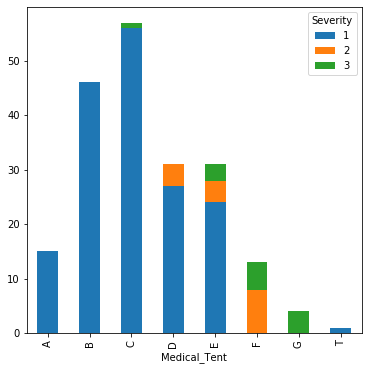

In [12]:
# Visual exploration of the cross table
table1.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

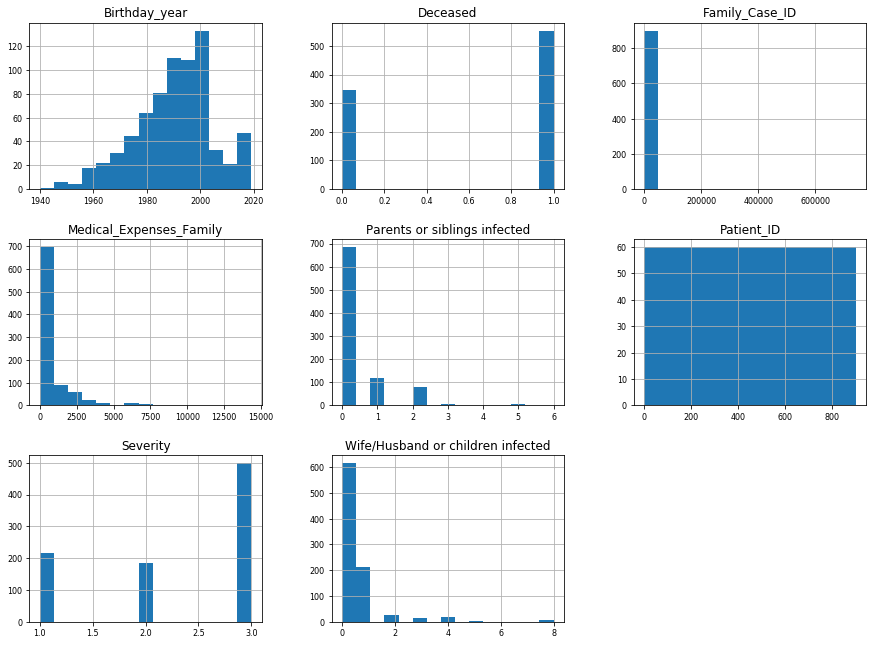

In [13]:
# Do histograms on all numeric variables
numerical=Pandemic.select_dtypes(include=[np.number]).columns.tolist()
Pandemic[numerical].hist(bins=15, figsize=(15, 15), layout=(4, 3), xlabelsize=8, ylabelsize=8);

Age has somewhat normal distribution, but Medical expenses need to be transformed. Also Infected family needs to be looked at.

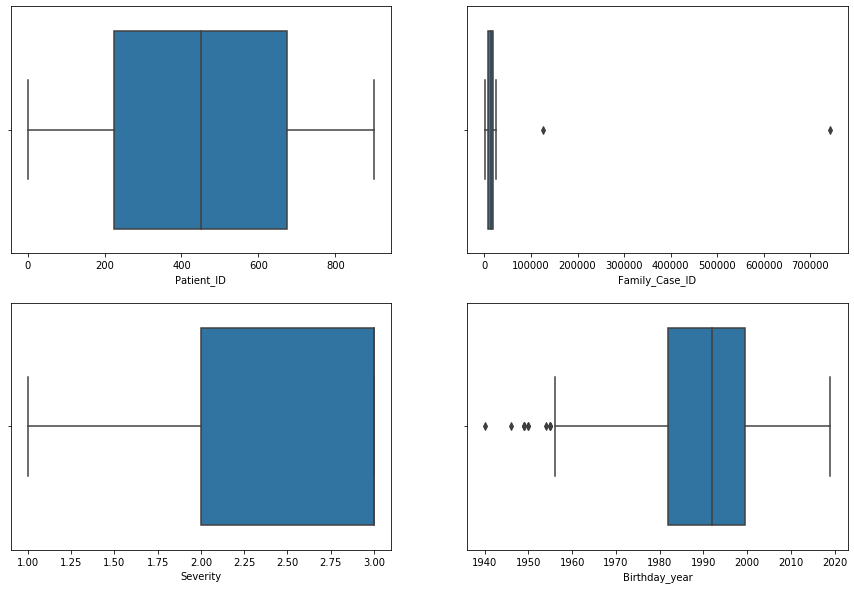

In [14]:
# Boxplots on all numeric variables
plt_box(Pandemic[numerical])

### Exploration of variables in relation to target

In [15]:
#average metrics for Deceased and Survivors to get initial insights
Pandemic.groupby('Deceased').mean()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family
Deceased,,,,,,,
0,449.423631,13619.536023,1.962536,1991.698305,0.463977,0.475504,1340.755043
1,451.175407,14736.466546,2.533454,1989.280374,0.327306,0.549729,616.504521


In [16]:
#Exploring categorical features
piv1=pd.pivot_table(Pandemic, values='Patient_ID', index=['City'], columns=['Deceased'],aggfunc='count')
piv2=pd.pivot_table(Pandemic, values='Patient_ID', index=['Severity'], columns=['Deceased'],aggfunc='count')
piv3=pd.pivot_table(Pandemic, values='Patient_ID', index=['Medical_Tent'], columns=['Deceased'],aggfunc='count')

display_side_by_side(piv1,piv2,piv3)


Deceased,0,1
City,,
Albuquerque,94,75
Santa Fe,221,428
Taos,30,50
Deceased,0,1
Severity,,
1,136,80
2,88,98
3,123,375
Deceased,0,1


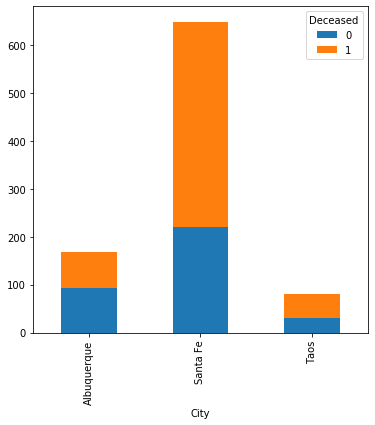

In [17]:
piv1.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

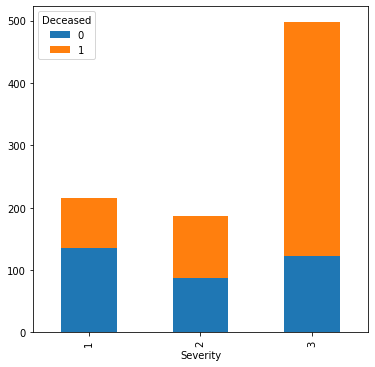

In [18]:
piv2.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

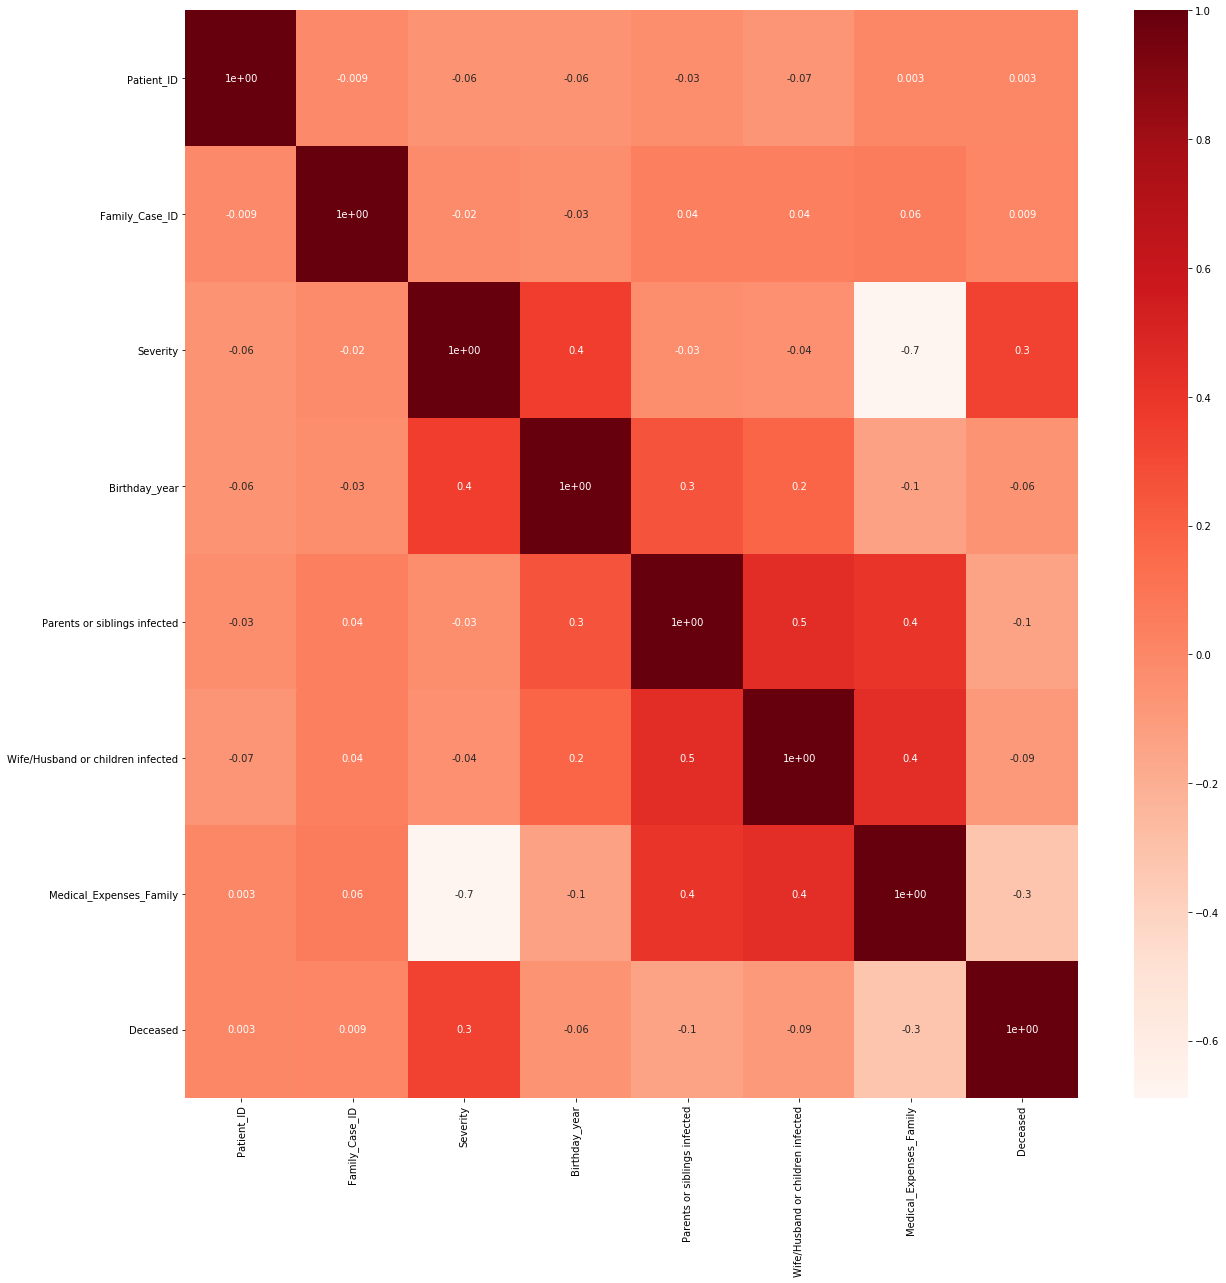

In [19]:
corr_df = Pandemic.corr('spearman')
cor_heatmap(corr_df)

In [20]:
abs(corr_df['Deceased']).sort_values(ascending=False)

Deceased                             1.000000
Severity                             0.334289
Medical_Expenses_Family              0.319579
Parents or siblings infected         0.140860
Wife/Husband or children infected    0.093854
Birthday_year                        0.058452
Family_Case_ID                       0.009041
Patient_ID                           0.003282
Name: Deceased, dtype: float64

**Some conclusions relating to target variable and input features**

* Family infected - younger patients die less, lower average in "Parents or siblings infected" can be explained by this. Also the two variables for infected in family seem to relay similar info so potentially can be merged into one feature "Family members infected" which reflects sum of the two columns
* Discard of "Medical_Tent" as almost 80% records do not have it or replace nulls with 9th category "No Tent"
* Create age variable
* Santa Fe has worst situation for severity of disease and number of infected, Albuquerque is next in number of infected but still has more people with lighter form of illness than the severe
* Survivors have spent more on medical expenses
* Severity, Medical expenses and Birthday Year are highly correlated.
* Partners/kids and parents/siblings are correlated

 **Severity, Medical expenses and infected family are most important features for the outcome of the illness**


## Pre-Processing

In [21]:
print(Pandemic.isnull().sum())

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64


In [22]:
Pandemic

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0
...,...,...,...,...,...,...,...,...,...,...,...
895,896,6253,3,Ms. Linda Wilcox,1998.0,1,1,344,NaN,Santa Fe,0
896,897,6483,3,Mr. Haiden Vance,2006.0,0,0,258,NaN,Santa Fe,0
897,898,981,3,Miss Anaiya Love,1990.0,0,0,214,NaN,Taos,1
898,899,16418,2,Mr. Robert Williams,1994.0,1,1,812,NaN,Santa Fe,0


In [23]:
#dropping missing city
Pandemic.dropna(subset=['City'],axis=0,inplace=True)

In [24]:
#filling the missing Medical tent with "None"
Pandemic['Medical_Tent'].fillna('None',inplace=True)

In [25]:
Pandemic

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,None,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,None,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,None,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,None,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,None,Santa Fe,0
...,...,...,...,...,...,...,...,...,...,...,...
895,896,6253,3,Ms. Linda Wilcox,1998.0,1,1,344,None,Santa Fe,0
896,897,6483,3,Mr. Haiden Vance,2006.0,0,0,258,None,Santa Fe,0
897,898,981,3,Miss Anaiya Love,1990.0,0,0,214,None,Taos,1
898,899,16418,2,Mr. Robert Williams,1994.0,1,1,812,None,Santa Fe,0


#### KNN Imputer for Birthday Year

In [26]:
imputer = KNNImputer(n_neighbors=3)


In [27]:
imputer.fit(Pandemic[['Birthday_year']])

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=3, weights='uniform')

In [28]:
Birthday_imputed = imputer.transform(Pandemic[['Birthday_year']])

In [29]:
Birthday_imputed = pd.DataFrame(Birthday_imputed, columns = Pandemic[['Birthday_year']].columns, index = Pandemic.index)

In [30]:
Birthday_imputed = Birthday_imputed.astype(int)
Birthday_imputed

,Birthday_year
0,1990
1,1966
2,1982
3,1997
4,1994
...,...
895,1998
896,2006
897,1990
898,1994


In [35]:
Pandemic = Pandemic.assign(Birthday_year=Birthday_imputed['Birthday_year'])
Pandemic

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,1990,0,0,225,None,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966,0,1,1663,None,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982,0,0,221,None,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997,0,0,220,None,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994,0,0,222,None,Santa Fe,0
...,...,...,...,...,...,...,...,...,...,...,...
895,896,6253,3,Ms. Linda Wilcox,1998,1,1,344,None,Santa Fe,0
896,897,6483,3,Mr. Haiden Vance,2006,0,0,258,None,Santa Fe,0
897,898,981,3,Miss Anaiya Love,1990,0,0,214,None,Taos,1
898,899,16418,2,Mr. Robert Williams,1994,1,1,812,None,Santa Fe,0


Check missing values in dataset

In [36]:
print(Pandemic.isnull().sum())

Patient_ID                           0
Family_Case_ID                       0
Severity                             0
Name                                 0
Birthday_year                        0
Parents or siblings infected         0
Wife/Husband or children infected    0
Medical_Expenses_Family              0
Medical_Tent                         0
City                                 0
Deceased                             0
dtype: int64


In [37]:
#create new variables age and Family infected 
Pandemic['Age']=2020-Pandemic['Birthday_year']
Pandemic.drop(['Birthday_year'],axis=1,inplace=True)

#create new variable Family_infected
#Pandemic['Family_infected']=Pandemic['Parents or siblings infected']+Pandemic['Wife/Husband or children infected']
#Pandemic.drop(['Parents or siblings infected','Wife/Husband or children infected'],axis=1,inplace=True)


In [38]:
#log tranformation for Expenses
#Pandemic['Log_expenses'] = np.log1p(Pandemic['Medical_Expenses_Family'])
#Pandemic.drop(['Medical_Expenses_Family'],axis=1,inplace=True)

In [39]:
#replacing missing age with predictions
#from sklearn.impute import KNNImputer
#imputer = KNNImputer(n_neighbors=3)
#imputer.fit(Pandemic)
#filled_data = imputer.transform(Pandemic)

In [40]:
#drop outliers?
#Med expenses

In [41]:
#maybe bin age

In [42]:
#drop name column
Pandemic.drop(['Name',"Patient_ID","Family_Case_ID"],axis=1,inplace=True)

#### Encoding categorical

In [49]:
# Encode categorical variables to dummy variables
import category_encoders as ce
encode = ['City', 'Medical_Tent']
ce_one_hot = ce.OneHotEncoder(cols = encode, use_cat_names=True)
encoded = ce_one_hot.fit_transform(Pandemic[encode])

complete = pd.concat([Pandemic, encoded], axis=1)
complete.drop(encode,axis=1,inplace=True)

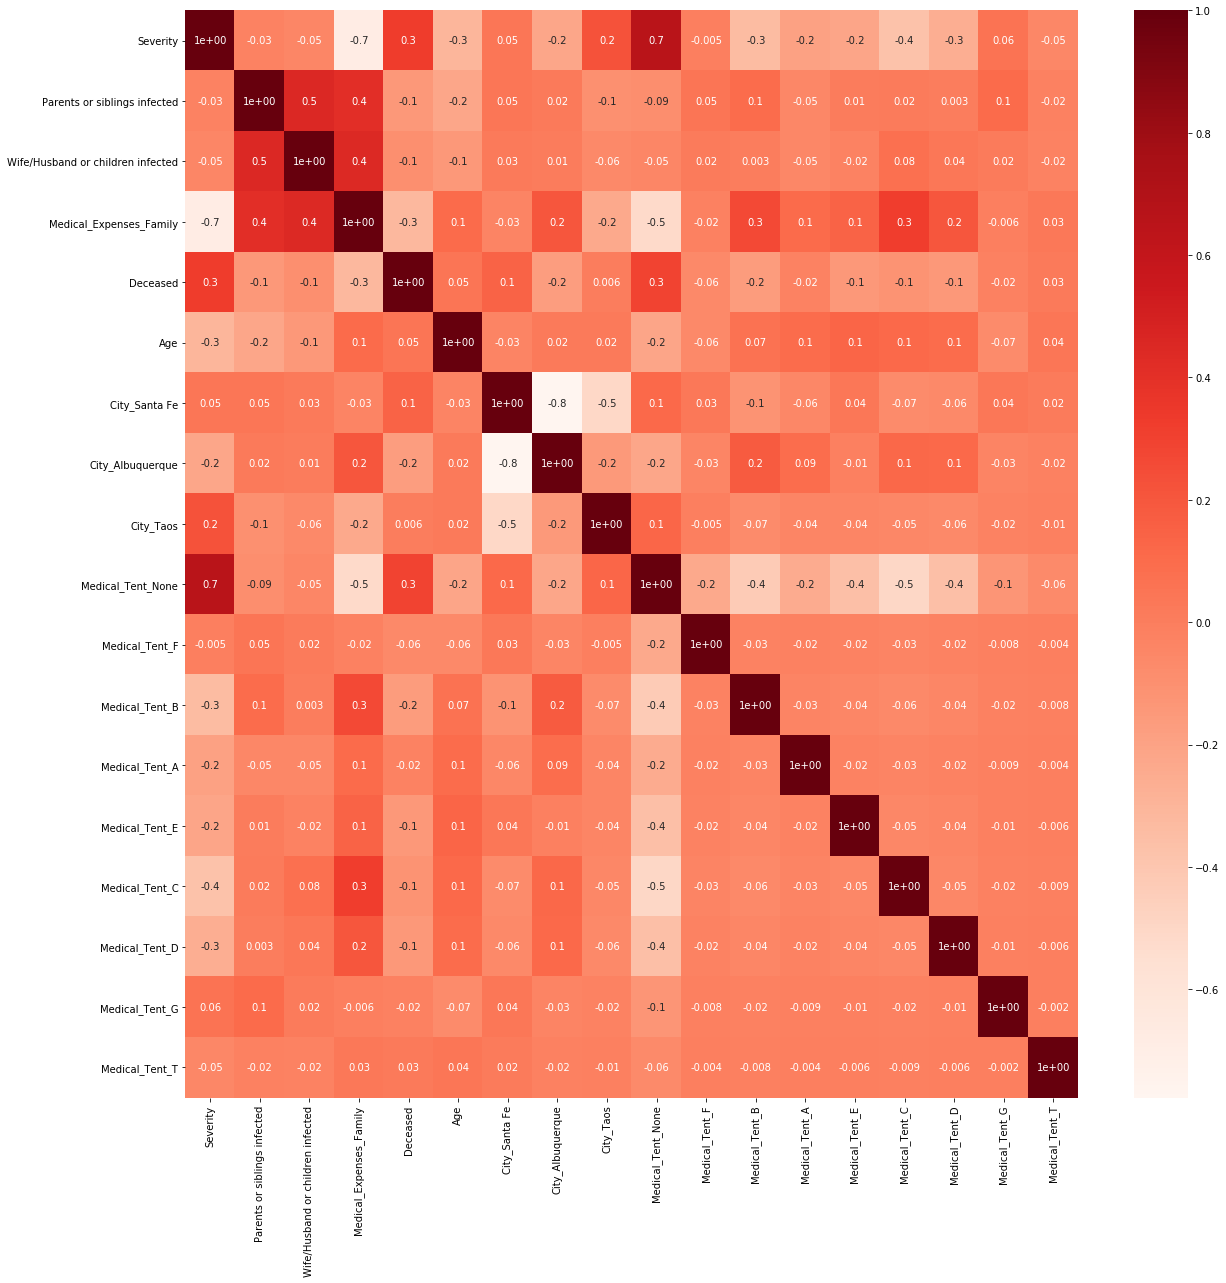

In [50]:
cor_heatmap(complete.corr('spearman'))

In [76]:
# drop high correlated variables where it makes sense
complete.drop('City_Albuquerque', axis=1, inplace=True)

In [80]:
abs(complete.corr()['Deceased']).sort_values(ascending=False)

Deceased                        1.000000
Severity                        0.330357
Medical_Expenses_Family         0.252494
Medical_Tent_B                  0.160105
City_Santa Fe                   0.144925
Medical_Tent_D                  0.139076
Medical_Tent_E                  0.139076
Medical_Tent_C                  0.113632
Parents or siblings infected    0.084364
Age                             0.079661
City_Taos                       0.005907
Name: Deceased, dtype: float64

In [52]:
#Split into data and target: X contains independent variables (before scaling) and y contains target
X = complete.drop(['Deceased'], axis=1)
y = complete['Deceased']

## Feature engineering

#### Bin Age

In [53]:
Pandemic['Age_label'] = pd.cut(x = Pandemic['Age'], bins = [0, 17, 29, 45, 59, 80, 110], labels = [0, 1, 2, 3, 4, 5])
Pandemic['Age_label'] = pd.cut(x = Pandemic['Age'], bins = [0, 17, 29, 45, 59, 80, 110], labels = [0, 1, 2, 3, 4, 5])

In [54]:
Pandemic['Age_label'] = Pandemic['Age_label'].astype('int')
Pandemic['Age_label'] = Pandemic['Age_label'].astype('int')

In [55]:
Pandemic

,Severity,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased,Age,Age_label
0,3,0,0,225,None,Santa Fe,1,30,2
1,1,0,1,1663,None,Albuquerque,0,54,3
2,3,0,0,221,None,Santa Fe,1,38,2
3,3,0,0,220,None,Santa Fe,1,23,1
4,3,0,0,222,None,Santa Fe,0,26,1
...,...,...,...,...,...,...,...,...,...
895,3,1,1,344,None,Santa Fe,0,22,1
896,3,0,0,258,None,Santa Fe,0,14,0
897,3,0,0,214,None,Taos,1,30,2
898,2,1,1,812,None,Santa Fe,0,26,1


# Feature selection

In [81]:
scaler = StandardScaler().fit(X)
X = pd.DataFrame(scaler.transform(X),columns=X.columns)

### RFE

In [82]:
model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 14)
X_rfe = rfe.fit_transform(X = X, y = y)
model.fit(X=X_rfe, y = y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [83]:
rfe.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 1, 1, 1, 1, 3, 1])

In [84]:
selected_features = pd.Series(rfe.support_, index = X.columns)
selected_features

Severity                              True
Parents or siblings infected          True
Wife/Husband or children infected     True
Medical_Expenses_Family               True
Age                                   True
City_Santa Fe                         True
City_Albuquerque                      True
City_Taos                             True
Medical_Tent_None                     True
Medical_Tent_F                       False
Medical_Tent_B                       False
Medical_Tent_A                        True
Medical_Tent_E                        True
Medical_Tent_C                        True
Medical_Tent_D                        True
Medical_Tent_G                       False
Medical_Tent_T                        True
dtype: bool

## Lasso Regression

In [85]:
reg = LassoCV()
reg.fit(X=X, y=y)
print("Best alpha: %f" % reg.alpha_)

Best alpha: 0.005262


In [86]:
coef = pd.Series(reg.coef_, index=X.columns)
coef.sort_values()

Medical_Tent_E                      -0.038860
Parents or siblings infected        -0.030954
Medical_Tent_D                      -0.028177
Medical_Expenses_Family             -0.026373
Medical_Tent_F                      -0.017813
Medical_Tent_B                      -0.010065
City_Taos                           -0.009940
Medical_Tent_G                      -0.003141
Medical_Tent_C                       0.000000
City_Albuquerque                    -0.000000
Medical_Tent_A                       0.005373
Medical_Tent_T                       0.010587
Medical_Tent_None                    0.011559
Wife/Husband or children infected    0.031634
City_Santa Fe                        0.045880
Age                                  0.093673
Severity                             0.142048
dtype: float64

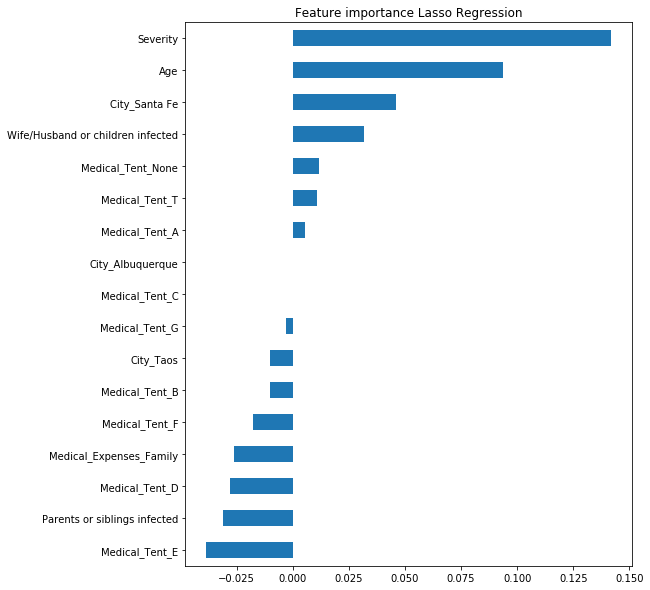

In [87]:
coef=coef.sort_values()
plt.figure(figsize=(8,10))
coef.plot(kind = "barh")
plt.title("Feature importance Lasso Regression")
plt.show()

## Ridge Regression

In [88]:
ridge = RidgeCV()
ridge.fit(X=X, y=y)
coef_ridge = pd.Series(ridge.coef_,index=X.columns)
coef_ridge

Severity                             0.147696
Parents or siblings infected        -0.037586
Wife/Husband or children infected    0.040435
Medical_Expenses_Family             -0.030431
Age                                  0.099670
City_Santa Fe                        0.030212
City_Albuquerque                    -0.014842
City_Taos                           -0.027112
Medical_Tent_None                    0.023799
Medical_Tent_F                      -0.018954
Medical_Tent_B                      -0.005374
Medical_Tent_A                       0.014611
Medical_Tent_E                      -0.037459
Medical_Tent_C                       0.013436
Medical_Tent_D                      -0.026685
Medical_Tent_G                      -0.006004
Medical_Tent_T                       0.016650
dtype: float64

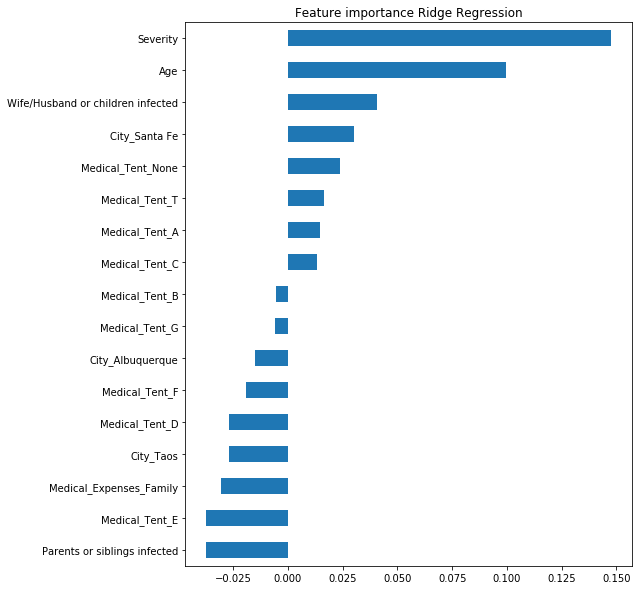

In [89]:
coef=coef_ridge.sort_values()
plt.figure(figsize=(8,10))
coef.plot(kind = "barh")
plt.title("Feature importance Ridge Regression")
plt.show()

## Feature Importance Random Forest 

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.3, 
                                                    random_state = 150,
                                                    shuffle = True, 
                                                    stratify = y)

In [91]:
clf=RandomForestClassifier()
clf.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<Figure size 576x720 with 0 Axes>

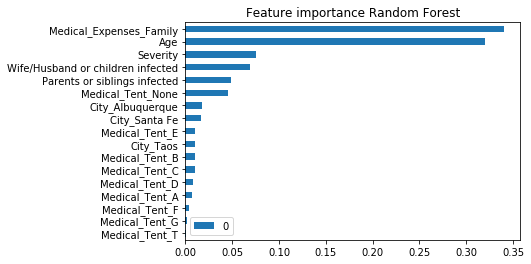

In [92]:
fi=pd.DataFrame(clf.feature_importances_, index=X_train.columns).sort_values(by=0)
plt.figure(figsize=(8,10))
fi.plot(kind = "barh")
plt.title("Feature importance Random Forest")
plt.show()

In [93]:
complete

,Severity,Parents or siblings infected,Medical_Expenses_Family,Deceased,Age,City_Santa Fe,City_Taos,Medical_Tent_B,Medical_Tent_E,Medical_Tent_C,Medical_Tent_D
0,3,0,225,1,30,1,0,0,0,0,0
1,1,0,1663,0,54,0,0,0,0,0,0
2,3,0,221,1,38,1,0,0,0,0,0
3,3,0,220,1,23,1,0,0,0,0,0
4,3,0,222,0,26,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
895,3,1,344,0,22,1,0,0,0,0,0
896,3,0,258,0,14,1,0,0,0,0,0
897,3,0,214,1,30,0,1,0,0,0,0
898,2,1,812,0,26,1,0,0,0,0,0


In [72]:
#todrop = ['Patient_ID','Family_Case_ID', 'Name',
 #      'Medical_Tent_A', 'Medical_Tent_None',
  #     'Medical_Tent_G', 'Medical_Tent_F', 'Medical_Tent_T','Wife/Husband or children infected']

todrop = ['Medical_Tent_A', 'Medical_Tent_None', 'Medical_Tent_G', 'Medical_Tent_F', 'Medical_Tent_T',
          'Wife/Husband or children infected']

In [73]:
#drop variables based on low correlations with target and high mutual correlations
complete.drop(todrop,axis=1,inplace=True)

In [77]:
complete.columns

Index(['Severity', 'Parents or siblings infected', 'Medical_Expenses_Family',
       'Deceased', 'Age', 'City_Santa Fe', 'City_Taos', 'Medical_Tent_B',
       'Medical_Tent_E', 'Medical_Tent_C', 'Medical_Tent_D'],
      dtype='object')

In [78]:
complete.head()

,Severity,Parents or siblings infected,Medical_Expenses_Family,Deceased,Age,City_Santa Fe,City_Taos,Medical_Tent_B,Medical_Tent_E,Medical_Tent_C,Medical_Tent_D
0,3,0,225,1,30,1,0,0,0,0,0
1,1,0,1663,0,54,0,0,0,0,0,0
2,3,0,221,1,38,1,0,0,0,0,0
3,3,0,220,1,23,1,0,0,0,0,0
4,3,0,222,0,26,1,0,0,0,0,0


## Train and Validation Normalized

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.3, 
                                                    random_state = 150,
                                                    shuffle = True, 
                                                    stratify = y)

In [ ]:
# Normalize all independent variables and create scaler based on train set. X_train = scaled training set, X_test = scaled test set
X_train_array = X_train.values # returns a numpy array
X_test_array = X_test.values
min_max_scaler = MinMaxScaler()
X_train_scaler = min_max_scaler.fit(X_train_array)
X_train_scaled = X_train_scaler.transform(X_train_array)
X_test_scaled = X_train_scaler.transform(X_test_array)
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

## Classifier

### 1. Multi-Layer Perceptron with default settings = Baseline

Default for MLPClassifier
parameter_space = {
    'hidden_layer_sizes': (100,),
    'activation': 'relu',
    'solver': 'adam',
    'learning_rate_init': 0.001,
    'learning_rate': 'constant',
    'alpha': 0.0001
    'batch_size':200,
    'max_iter':200,
    'shuffle':True
    'random_state':None,
    'tol':1e-4.
    'momentum':0.9 (between 0 and 1),
    'early_stopping':False,
    'validation_fraction': 0.1(for early_stopping)
}

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
model = MLPClassifier(random_state=150)

In [ ]:
df = pd.DataFrame(columns = ['Time','Train','Test', 'Iterations'], index = ['Baseline'])
show_results(df, model)

Models to try out
 - Bayes
 - Random Forest
 - Xgboost
 - GBD
 - Support Vector Machine
 - KNN
 - tuning MLPClassifier/Optuna, Randomized Search i/o GridSearch
 
 